In [1]:
%matplotlib inline

import numpy as np
import warnings
warnings.filterwarnings('ignore')
from  tqdm import tqdm

import contextlib
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)


In [2]:
import sys
sys.path.append("./src")

%load_ext autoreload
%autoreload 2
import wannier_loader 
import exchange_GG

In [3]:
HighSymPointsNames = [ 'G', 'M', 'K', 'G']
HighSymPointsDists = [0. , 0.97778934, 1.54231628, 2.67137017]
# qe2wan = 1.6935274297723675

In [20]:
# read target kpath in integer units (see example)
kpath = []
kpath_draw = []
with open("./kpaths/kpath_integer.dat") as f:
        for line in f:
            hr_string = line.split()
            kpath.append([int(hr_string[1]), int(hr_string[2])])
            kpath_draw.append(float(hr_string[4]))
kpath = np.array(kpath)

# $H_{m m'}(R)$

In [12]:
wannier_dir = './data/1layer/'
loader = wannier_loader.Wannier_loader_FM(wannier_dir)

nwa  11
Rpts 403
we have 2D hamiltonian
nwa  11
Rpts 403
we have 2D hamiltonian


In [13]:
nkpt = 24

loader.get_dense_hk(nkpt=nkpt)

100%|██████████| 576/576 [00:01<00:00, 375.06it/s]


In [14]:
hks = np.transpose(loader.hks_spins, (3, 2, 0, 1))
hk_mn_up = hks[0] 
hk_mn_dn = hks[1] 

In [15]:
hk_mn_up.shape

(576, 11, 11)

# Delta

In [16]:
dSarea = 1.0/(nkpt**2)
Delta = np.real(dSarea*np.sum(hk_mn_up - hk_mn_dn, axis=0 ))

assert np.linalg.norm(np.conj(Delta.T) - Delta) < 1e-9 , 'Delta is not hermitian'

## can zero out p orbitals
# Delta[:4, :4] = 0
# Delta[4:, :4] = 0
# Delta[:4, 4:] = 0

with printoptions(precision=2, suppress=True):
    print(Delta)


[[-0.04 -0.   -0.    0.05  0.04 -0.02 -0.12 -0.    0.02 -0.06  0.  ]
 [-0.    0.01  0.    0.04  0.03 -0.03  0.   -0.08 -0.   -0.    0.13]
 [-0.   -0.    0.01 -0.02 -0.03 -0.01 -0.07  0.    0.04 -0.05 -0.  ]
 [ 0.05  0.04 -0.02 -0.04 -0.   -0.    0.12  0.02  0.01 -0.03 -0.05]
 [ 0.04  0.03 -0.03 -0.    0.01 -0.   -0.06 -0.01 -0.05  0.08 -0.  ]
 [-0.02 -0.03 -0.01 -0.    0.    0.01 -0.03 -0.05  0.05 -0.09  0.08]
 [-0.12  0.   -0.07  0.12 -0.06 -0.03 -2.54  0.   -0.   -0.   -0.  ]
 [-0.   -0.08  0.    0.02 -0.01 -0.05  0.   -1.88 -0.    0.    0.39]
 [ 0.02  0.    0.04  0.01 -0.05  0.05 -0.   -0.   -1.88  0.39  0.  ]
 [-0.06 -0.   -0.05 -0.03  0.08 -0.09 -0.    0.    0.39 -2.21 -0.  ]
 [ 0.    0.13 -0.   -0.05 -0.    0.08 -0.    0.39  0.   -0.   -2.21]]


# J(q)

In [17]:
eF = -1.014 # fermi E in eV
beta = 10
n_iw = 200
S = 1.5 # spin

exchanges = exchange_GG.Exchanges(hk_mn_up, hk_mn_dn, Delta, S, eF, beta, n_iw)

100%|██████████| 576/576 [00:03<00:00, 169.65it/s]


J = 1355.17340-0.00000j meV


In [21]:
# calculate J(q) along kpath
Jqs = exchanges.getJpath(kpath)

100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


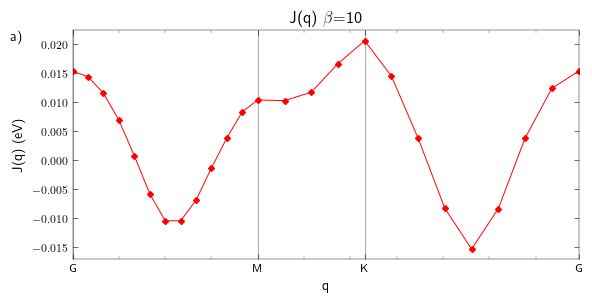

In [22]:
exchanges.plot(Jqs, HighSymPointsDists, HighSymPointsNames, kpath_draw, saveQ=False)

# J(R)

In [74]:
# lattice vectors in A
a = np.array([[ 3.71000027,  0.        ,  0.        ],
              [-1.85500013,  3.21295448,  0.        ],
              [ 0.        ,  0.        , 20.00000144]])


vert = {}
num_vert=20
for i_index in range(-num_vert, num_vert):
    for j_index in range(-num_vert, num_vert):
        pair = [i_index, j_index]
        dist = np.round(np.linalg.norm(i_index*a[0] + j_index*a[1]), 2)
        if dist not in vert: 
            vert[dist]=[pair]
        else:
            vert[dist].append(pair)

# dist <-> [coords] in reciprocial vectors units
sorted_vert_J = dict(sorted(vert.items())[1:10])
print(sorted_vert_J)

#coords of neighbours
J_path = [ np.array(x)[:, np.newaxis] for y in list(sorted_vert_J.values()) for x in y]

tmp = [len(x)*[i+1]  for i, x in enumerate(list(sorted_vert_J.values()))]
J_path_plt = [ x for y in tmp for x in y] #list of neighbours orders

print('\n')
print(J_path_plt)
print(len(J_path_plt))

{3.71: [[-1, -1], [-1, 0], [0, -1], [0, 1], [1, 0], [1, 1]], 6.43: [[-2, -1], [-1, -2], [-1, 1], [1, -1], [1, 2], [2, 1]], 7.42: [[-2, -2], [-2, 0], [0, -2], [0, 2], [2, 0], [2, 2]], 9.82: [[-3, -2], [-3, -1], [-2, -3], [-2, 1], [-1, -3], [-1, 2], [1, -2], [1, 3], [2, -1], [2, 3], [3, 1], [3, 2]], 11.13: [[-3, -3], [-3, 0], [0, -3], [0, 3], [3, 0], [3, 3]], 12.85: [[-4, -2], [-2, -4], [-2, 2], [2, -2], [2, 4], [4, 2]], 13.38: [[-4, -3], [-4, -1], [-3, -4], [-3, 1], [-1, -4], [-1, 3], [1, -3], [1, 4], [3, -1], [3, 4], [4, 1], [4, 3]], 14.84: [[-4, -4], [-4, 0], [0, -4], [0, 4], [4, 0], [4, 4]], 16.17: [[-5, -3], [-5, -2], [-3, -5], [-3, 2], [-2, -5], [-2, 3], [2, -3], [2, 5], [3, -2], [3, 5], [5, 2], [5, 3]]}


[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
72


In [116]:
# # calculate J(R) in neighbours list from fourier of J(q) VERY SLOW
# Js = exchanges.JsReal(J_path)

100%|██████████| 72/72 [00:00<00:00, 262.20it/s]


In [105]:
# calculate J(R) in neighbours list 
Js =  np.array([ exchanges.calc_J(r.flatten(), 0) for r in tqdm(J_path)])

100%|██████████| 72/72 [00:03<00:00, 18.76it/s]


	 #Neib   	 Sum J (meV)  	 J mean (meV)
--------------------------------------------------
             6	             -7.22	             -1.20             
             6	             18.12	             3.02             
             6	             10.37	             1.73             
             12	             -4.17	             -0.35             
             6	             0.30	             0.05             
             6	             -0.68	             -0.11             
             12	             -2.01	             -0.17             
             6	             -0.15	             -0.03             
             12	             -0.24	             -0.02             
Total 14.33 (meV) FM


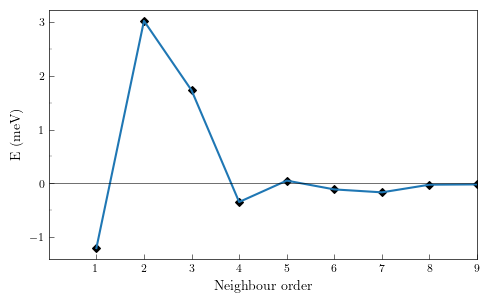

In [118]:
exchange_GG.plotJ_Real(Js, sorted_vert_J, J_path_plt)